In [319]:
# conda create --name Env_VectoRaster

In [320]:
#conda create -n envFjell
#conda activate envFjell
#conda config --env --add channels conda-forge
#conda config --env --set channel_priority strict
#conda install geopandas
##conda install pyogrio # følger med geopandas
#conda install fiona
#conda install rasterio
# conda install pyarrow

In [321]:
import geopandas as gpd
import pyogrio
import fiona
import rasterio as rio
import numpy as np 
# import pyarrow
# pyarrow fungerer ikke i min conda env
import os

In [322]:
import pandas as pd
arter = pd.read_excel("C:/data/Artsliste_Naturtyper_fra_ADB_20220629_vers2.xlsx", sheet_name="Artslister_NiN")

In [356]:
tmp = arter['Kategori'][20].split(",")
tmp = [str.strip(element) for element in tmp if 'KA' in element]
tmp
#tmp.contains("KA")
# tmp[tmp.str.contains("KA")]
# for i in tmp:
#     tmp[tmp.str.contains("KA")]

['s*[KA·h|g]']

In [323]:
#
# Fjern de som mangler kategori
arter = arter[~arter["Kategori"].isna()]
# Behold de som er relevant mtp kalkgradienten
arter = arter[arter["Kategori"].str.contains("KA")]
# Behold den som er kjennetegnede for skille og tyndepunktsgradient
arter = arter[arter["Kategori"].str.contains("s|t¤")]
# Function to find "KA" and extract the part 2-4 positions behind it
def extract_behind_ka(s, find = "KA", pos1=3, pos2=6):
    kid = s.find(find)
    return s[(kid+pos1):(kid+pos2)]
    #else:
    #    return None
# Apply the function to the 'Kategori' column
arter['KA_Skille'] = arter['Kategori'].apply(extract_behind_ka, find = "KA", pos1 = 3, pos2 = 6)
arter['KA_Skillestyrke'] = arter['Kategori'].apply(extract_behind_ka, find = "KA", pos1 = -3, pos2 = -1)
arter['KA_Skilletrinn']=arter['KA_Skille'].apply(lambda x: x[0])

#t¤

In [324]:
#arter[['Populærnavn', "VitNavn","KE","KE_kode",  "KA_Trinn", "KA_Styrke"]].drop_duplicates()

arter[['Populærnavn', "VitNavn",'KA_Skille',  "KA_Skilletrinn", "KA_Skillestyrke"]].drop_duplicates()

,Populærnavn,VitNavn,KA_Skille,KA_Skilletrinn,KA_Skillestyrke
0,Granmose,Abietinella abietina,h|g,h,s-
6,Granmose,Abietinella abietina,g|f,g,s-
7,Granmose,Abietinella abietina,f|e,f,s*
19,Granmose,Abietinella abietina,h|g,h,s*
26,Ryllik,Achillea millefolium,d|c,d,s+
...,...,...,...,...,...
6870,Engtjæreblom,Viscaria vulgaris,d|c,d,s+
6882,Vassnøkkemose,Warnstorfia fluitans,d|e,d,s-
6883,Vassnøkkemose,Warnstorfia fluitans,d|e,d,s+
6884,Tannkrusmose,Weissia controversa,g|f,g,s+


In [325]:
# Beholder bare de som er skille mellom hovedtrinn langs gradienten, Utelat de som er skiller innad i gradienten
# arter = arter[~arter['KA_Skilletrinn'].str.contains("e|h")]
#arter[arter["KA_Skille	"].str.contains("g")] & arter[arter["KA_Skille"].str.contains("h")]

In [326]:
# Fjern det som ikke er på artsnivå
arter = arter[arter["VitNavn"].apply(lambda x: " " in x)]
#arter = arter[]
utvalg = arter[arter['KA_Skillestyrke']!="s-"]["VitNavn"].drop_duplicates()


In [327]:
utvalg[2:4]
#utvalg[0:4]

41            Acinos arvensis
50    Aconitum septentrionale
Name: VitNavn, dtype: object

In [328]:
# Use groupby and sample to get one row per group
utvalg = arter.groupby('KA_Skillestyrke').apply(lambda x: x.sample(n=1)).reset_index(drop=True)["VitNavn"]

C:\Users\endre\AppData\Local\Temp\ipykernel_20860\3226269279.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  utvalg = arter.groupby('KA_Skillestyrke').apply(lambda x: x.sample(n=1)).reset_index(drop=True)["VitNavn"]


# GBIF

In [329]:
# set up request function
import requests
import pandas as pd
base_url = "https://api.gbif.org/v1/occurrence/search?"
countryCode = "NO"
def get_GBIF_response(base_url, offset, params, df, maxCount = None, i = None):
    """Performs an API call to the base URL with additional parameters listed in 'params'. Concatenates response to a Pandas DataFrame, 'df'."""
    
    #Construct the query URL
    query = base_url+'&'+f'offset={offset}'
    for each in params:
        query = query+'&'+each
            
    #Call API
    #print(query)
    response = requests.get(query)
    
    #If call is successful, add data to df
    if response.status_code != 200:
        print(f"API call failed at offset {offset} with a status code of {response.status_code}.")
    else:
        result = response.json()
        df2 = pd.DataFrame.from_dict(result['results'])
        if i is not None:
            df2['query'] = i
        df_concat = pd.concat([df, df2], axis = 0, ignore_index = True, sort = True)
        endOfRecords = result['endOfRecords']
        return df_concat, endOfRecords, response.status_code
#set parameters for API call
params0 = ['limit=100', 'publishingCountry=NO','hasGeospatialIssue=false', 'hasCoordinate=true','year=2010,2025','coordinateUncertaintyInMeters=0,250', 'county=Trøndelag']

In [330]:
# https://api.gbif.org/v1/occurrence/search?scientificName=Herminium%20monorchis&publishingCountry=NO&hasCoordinate=true&hasGeospatialIssue=false

In [331]:
#Set up a simple while loop to continue downloading until the last #page
df = pd.DataFrame()
endOfRecords = False
offset = 0
status = 200
# species to check
species = utvalg#[5:10]
# prefix for the request parameter
pre = 'scientificName='

for i in species:
    print(i)
    params = params0.copy()
    params.append(pre+i)
    while endOfRecords == False and status == 200:
        df, endOfRecords, status = get_GBIF_response(base_url, offset, params, df, i = i,maxCount = 100)
        endOfRecords = True # kommenterer bort denne når jeg vil begrense antall treff, og ikke ha alt
        print(offset)
        offset = len(df) + 1
    endOfRecords = False
    offset = 0
    status = 200

Pseudorchis straminea
0
Pilosella officinarum
0
Draba verna
0
Pimpinella saxifraga
0
Lathyrus linifolius
0
Peltigera praetextata
0
Solidago virgaurea
0


In [338]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['decimalLongitude'], df['decimalLatitude']))
gdf = gdf.query('decimalLongitude > 0 & decimalLatitude > 55 & coordinateUncertaintyInMeters<250')


In [339]:
gdf = gdf.merge(arter, left_on = 'query', right_on = 'VitNavn')
gdf = gdf.sort_values(by = 'KA_Skilletrinn') 

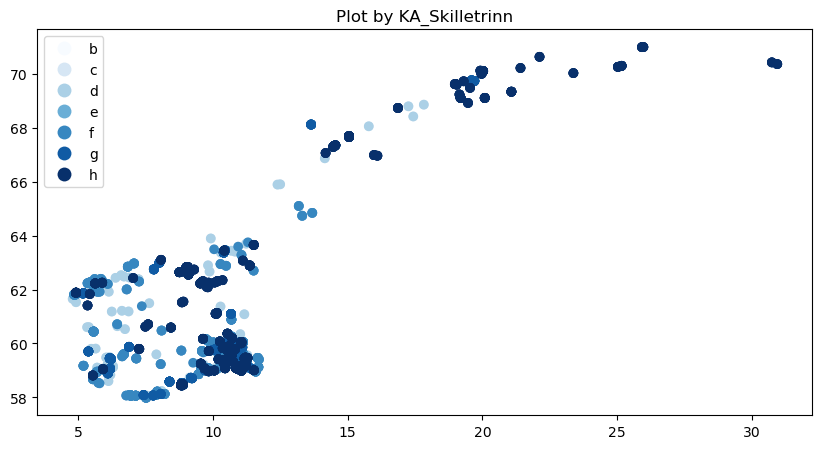

In [340]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming you have a GeoDataFrame named 'gdf' with the column 'KA_Skilletrinn'
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='KA_Skilletrinn', cmap='Blues', legend=True, ax=ax)
plt.title('Plot by KA_Skilletrinn')
plt.show()


# Kriging

In [12]:
import fiona
import numpy as np
import geopandas as gpd
import pyarrow

In [5]:
trondelag = gpd.read_file("c:/data/NUTS_RG_01M_2024_4326_LEVL_3.shp",use_arrow =True)
trondelag


,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry
0,AT112,3,AT,Nordburgenland,Nordburgenland,NaN,NaN,NaN,"POLYGON ((17.08112 48.0877, 17.07415 48.08386,..."
1,AT113,3,AT,Südburgenland,Südburgenland,NaN,NaN,NaN,"POLYGON ((16.30155 47.41531, 16.31131 47.40609..."
2,AL011,3,AL,Dibër,Dibër,NaN,NaN,NaN,"POLYGON ((20.3461 41.8761, 20.34106 41.85659, ..."
3,AL012,3,AL,Durrës,Durrës,NaN,NaN,NaN,"POLYGON ((19.8072 41.5662, 19.81828 41.56444, ..."
4,AL013,3,AL,Kukës,Kukës,NaN,NaN,NaN,"POLYGON ((20.11943 42.52485, 20.16464 42.50607..."
...,...,...,...,...,...,...,...,...,...
1340,XK004,3,XK,Prizren,Prizren,NaN,NaN,NaN,"POLYGON ((20.96126 42.43076, 20.96486 42.42823..."
1341,XK005,3,XK,Ferizaj,Ferizaj,NaN,NaN,NaN,"POLYGON ((20.97626 42.48519, 20.98502 42.478, ..."
1342,XK006,3,XK,Gjilan,Gjilan,NaN,NaN,NaN,"POLYGON ((21.5902 42.72572, 21.59262 42.71879,..."
1343,XK007,3,XK,Gjakovë,Gjakovë,NaN,NaN,NaN,"POLYGON ((20.78979 42.57889, 20.79362 42.57257..."


In [8]:
test = trondelag[trondelag['NUTS_ID']=="NO060"].to_crs("EPSG:25833")#.plot()
test

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry
890,NO060,3,NO,Trøndelag/Trööndelage,Trøndelag/Trööndelage,NaN,NaN,NaN,"MULTIPOLYGON (((465290.731 7222542.945, 466121..."


In [9]:
import geopandas as gpd
from shapely.geometry import Point
import random

def generate_random_point(geo_polygon):
    min_x, min_y, max_x, max_y = geo_polygon.total_bounds
    while True:
        random_point = Point(random.uniform(float(min_x), float(max_x)), random.uniform(float(min_y), float(max_y)))
        if geo_polygon.contains(random_point).any():
            return random_point

def generate_grid_points(geo_polygon, distance = 500):
    min_x, min_y, max_x, max_y = geo_polygon.total_bounds
    x_coords = np.arange(min_x, max_x, distance)
    y_coords = np.arange(min_y, max_y, distance)
    grid_points = [Point(x, y) for x in x_coords for y in y_coords if geo_polygon.contains(Point(x, y)).any()]
    grid_points = gpd.GeoDataFrame(geometry=grid_points,crs = geo_polygon.crs.to_epsg())
    return grid_points

In [25]:
# Sample 10 random points inside the polygon
num_points = 30
samplePoints = generate_grid_points(geo_polygon=test, distance = 5000)#[generate_random_point(geo_polygon) for _ in range(num_points)]

In [26]:
from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Get boundary MultiLineString
boundary = unary_union(test.geometry.boundary.iloc[0])

# Extract coordinates from each part of MultiLineString
boundary_coords = []
for line in boundary.geoms:
    boundary_coords.extend(list(line.coords))

# Create GeoDataFrame from boundary points
boundary_points = gpd.GeoDataFrame(
    geometry=[Point(x, y) for x, y in boundary_coords],
    crs=samplePoints.crs
)

# Add zero distances for boundary points
boundary_points['dist_to_boundary'] = 0

# Calculate distances for sample points
distances = [point.distance(boundary) for point in samplePoints.geometry]
samplePoints['dist_to_boundary'] = distances

# Combine sample points and boundary points
samplePoints = pd.concat([samplePoints, boundary_points], ignore_index=True)

In [27]:
x = samplePoints.geometry.x
y = samplePoints.geometry.y
z = samplePoints['dist_to_boundary']              # 1-dimensional array for z-values

# Grid to generate kriging
grid_points = generate_grid_points(geo_polygon = test, distance=1000)

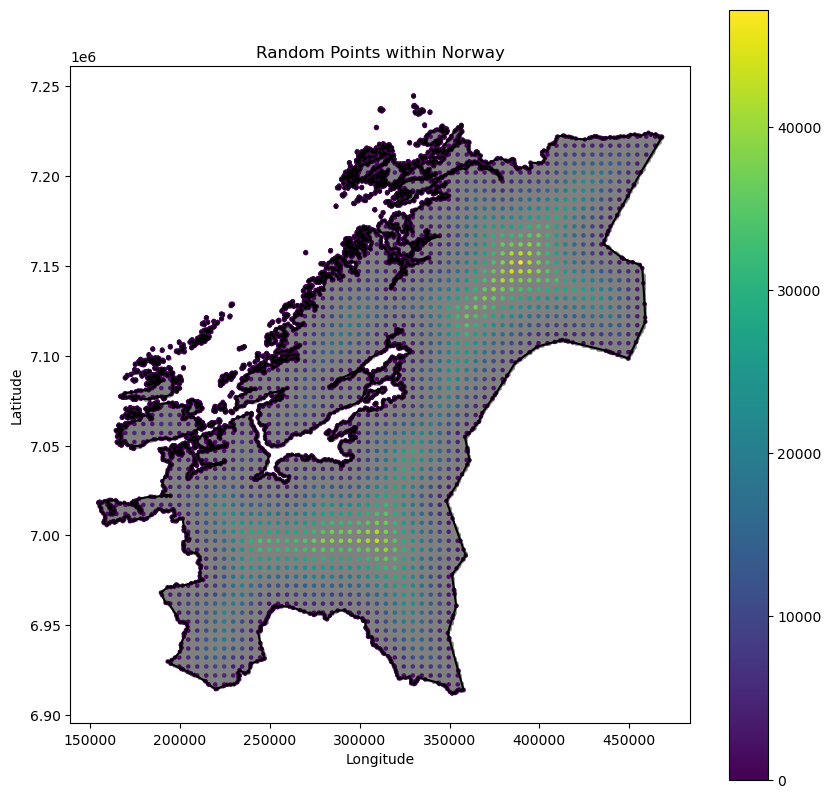

In [28]:
#gpd.GeoDataFrame(geometry=random_points, crs="EPSG:25833").plot()
import matplotlib.pyplot as plt
# Convert random points to a GeoDataFrame
points_gdf = grid_points
# Plot the polygon and the random points
fig, ax = plt.subplots(figsize=(10, 10))
test.boundary.plot(ax=ax, color='black')
points_gdf.plot(ax=ax, color='grey', markersize=5)
samplePoints.plot(column='dist_to_boundary', ax=ax, cmap='viridis', legend=True, markersize=5)
plt.title("Random Points within Norway")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

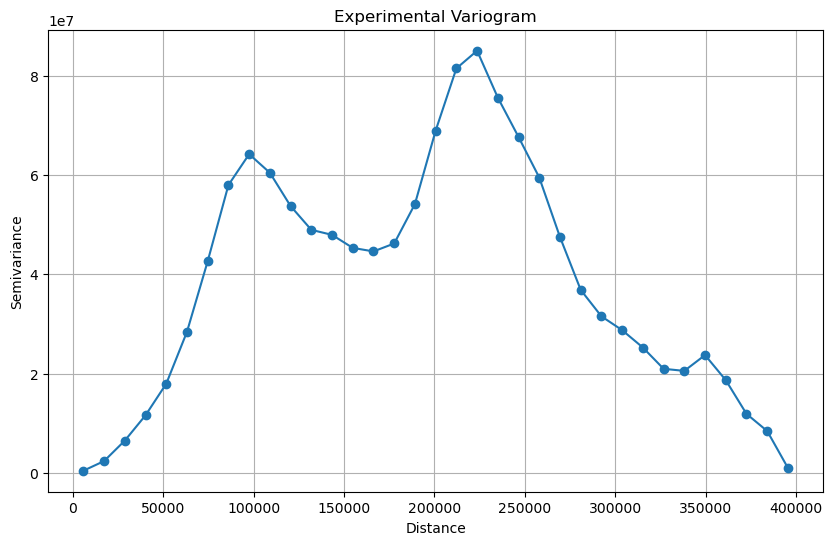

Estimated nugget (y-intercept): 434263.827
Estimated sill (plateau): 85030596.164


In [29]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
def calculate_experimental_variogram(x_coords, y_coords, values, n_lags=35):
    # Stack coordinates into 2D array
    coords = np.column_stack((x_coords, y_coords))
    
    # Calculate distances between all points
    distances = pdist(coords)
    
    # Calculate squared differences between all values
    sq_diffs = pdist(values.reshape(-1,1), metric='sqeuclidean')
    
    # Define distance bins
    max_dist = np.max(distances)
    bin_edges = np.linspace(0, max_dist, n_lags + 1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    
    # Calculate mean semivariance for each bin
    semivariance = np.zeros(n_lags)
    for i in range(n_lags):
        mask = (distances >= bin_edges[i]) & (distances < bin_edges[i+1])
        if np.any(mask):
            semivariance[i] = np.mean(sq_diffs[mask]) / 2
    
    return bin_centers, semivariance

# Example usage
x = samplePoints.geometry.x
y = samplePoints.geometry.y
values = samplePoints['dist_to_boundary'].values
# Calculate experimental variogram
distances, semivariance = calculate_experimental_variogram(x, y, values)


# Plot experimental variogram
plt.figure(figsize=(10, 6))
plt.plot(distances, semivariance, 'o-')
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.title('Experimental Variogram')
plt.grid(True)
plt.show()

# Print statistics to help estimate parameters
print(f"Estimated nugget (y-intercept): {semivariance[0]:.3f}")
print(f"Estimated sill (plateau): {np.max(semivariance):.3f}")
# Range can be estimated visually from the plot

In [ ]:
from pykrige.ok import OrdinaryKriging

# Define the variogram model
#variogram_model = 'linear'  # You can choose other models like 'power', 'gaussian', etc.
# Create an Ordinary Kriging object
eps = 1e-10
z_log = np.log(z + eps)


OK = OrdinaryKriging(
    x, y, z_log,
    variogram_model='spherical',
    variogram_parameters={
        'range': 75000,
        'sill': 1.0,
        'nugget': 0.001  # Add small nugget
    },
    coordinates_type='euclidean'
)

# 3. Execute with nearest neighbors constraint
z_est, ss = OK.execute(
    style='points',
    xpoints=np.array(points_gdf.geometry.x),
    ypoints=np.array(points_gdf.geometry.y),
    backend = 'C'
)
# Convert grid points to a GeoDataFrame
#points_gdf['z_est'] = (z_est)
points_gdf['z_est'] = np.exp(z_est) - eps

# Plot the polygon and the grid points with z_est values
fig, ax = plt.subplots()
#test.boundary.plot(ax=ax, color='black')
points_gdf.plot(column='z_est', ax=ax, legend=True, cmap='viridis', markersize=5)
plt.title("Grid Points with z_est values within Norway")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

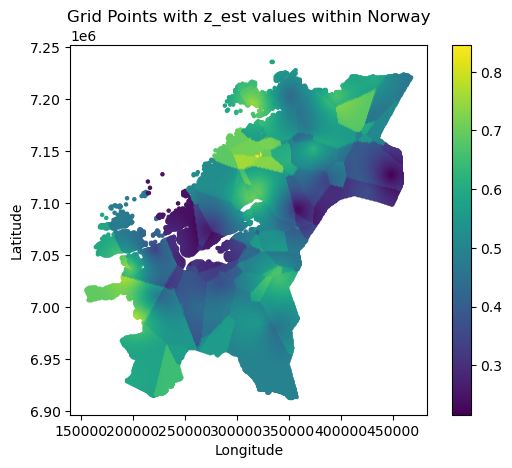